# Attack On Titan Network Analysis

In [37]:
#first step, importing the necessary libraries
import pandas as pd
import json
import networkx as nx
import matplotlib.pyplot as plt
from functools import reduce


### Data cleaning and preparation

In [4]:
DATA_PATH = "/Users/michelecoaro/Documents/GitHub/AOT_Network/Data/characters.json"

# Load data into a pandas DataFrame
with open(DATA_PATH, 'r', encoding='utf-8') as f:
    data = json.load(f)

df = pd.json_normalize(data)  # Convert list of dicts to df
print("Original DataFrame shape:", df.shape)

# Display a small sample to see the raw structure
df.head(3)


Original DataFrame shape: (201, 16)


,id,name,img,alias,species,gender,age,height,relatives,birthplace,residence,status,occupation,groups,roles,episodes
0,1,Armin Arlelt,https://static.wikia.nocookie.net/shingekinoky...,[Colossal Titan],"[Human, Intelligent Titan]",Male,19,60 m (Colossal Titan form),"[{'family': 'Arlelt family', 'members': ['Unna...",Shiganshina District,Wall Rose,Alive,Soldier,"[{'name': 'Scout Regiment', 'sub_groups': ['Sp...","[Colossal Titans, Scout Regiment Commanders]","[https://api.attackontitanapi.com/episodes/1, ..."
1,2,Mikasa Ackermann,https://static.wikia.nocookie.net/shingekinoky...,[],[Human],Female,19,unknown,"[{'family': 'Ackermann family', 'members': ['U...",Shiganshina District Outskirts? → Shiganshina ...,Wall Rose,Alive,Soldier,"[{'name': 'Scout Regiment', 'sub_groups': ['Sp...",[],"[https://api.attackontitanapi.com/episodes/1, ..."
2,3,Jean Kirschtein,https://static.wikia.nocookie.net/shingekinoky...,[Horse face],[Human],Male,19,unknown,"[{'family': 'Kirschtein family', 'members': ['...",Trost District,Wall Rose,Alive,Soldier,"[{'name': 'Scout Regiment', 'sub_groups': ['Sp...",[],"[https://api.attackontitanapi.com/episodes/2, ..."


In [5]:
# =================================================
# Cell 3: Data Cleaning and Preprocessing (Task 1)
# =================================================

# We only want to keep the following columns:
# 'id', 'name', 'alias', 'species', 'groups', 'roles', 'episodes'

columns_to_keep = [
    'id', 
    'name', 
    'alias', 
    'species', 
    'groups', 
    'roles', 
    'episodes'
]

df_cleaned = df[columns_to_keep].copy()

print("DataFrame shape after keeping necessary columns:", df_cleaned.shape)

# Display a snippet of the cleaned DataFrame
df_cleaned.head(3)


DataFrame shape after keeping necessary columns: (201, 7)


,id,name,alias,species,groups,roles,episodes
0,1,Armin Arlelt,[Colossal Titan],"[Human, Intelligent Titan]","[{'name': 'Scout Regiment', 'sub_groups': ['Sp...","[Colossal Titans, Scout Regiment Commanders]","[https://api.attackontitanapi.com/episodes/1, ..."
1,2,Mikasa Ackermann,[],[Human],"[{'name': 'Scout Regiment', 'sub_groups': ['Sp...",[],"[https://api.attackontitanapi.com/episodes/1, ..."
2,3,Jean Kirschtein,[Horse face],[Human],"[{'name': 'Scout Regiment', 'sub_groups': ['Sp...",[],"[https://api.attackontitanapi.com/episodes/2, ..."


In [6]:
# =========================================================
# Cell 4: Add a New Column for Seasons (Task 2)
# =========================================================
# We will parse the episode number from the episode URLs,
# then assign a season based on the episode number.

def get_episode_number(url):
    """
    Given an episode URL, extract the numerical part.
    For example: 'http://somesite.com/episodes/10' -> 10
    Adjust this logic according to your actual URL structure.
    """
    # Example assumption: the last part of the URL after '/' is the episode number
    return int(url.rstrip('/').split('/')[-1])

def determine_season(episode_num):
    """
    Determine the season based on episode_num:
       Season 1: 1–25
       Season 2: 26–37
       Season 3: 38–59
       Season 4: 60–94
    """
    if 1 <= episode_num <= 25:
        return 1
    elif 26 <= episode_num <= 37:
        return 2
    elif 38 <= episode_num <= 59:
        return 3
    elif 60 <= episode_num <= 94:
        return 4
    else:
        return None  # For safety, if anything is out of range

# We'll create a new column that includes all seasons a character appears in,
# based on all the episodes that character is in.
def get_character_seasons(episodes):
    """
    episodes: list of URL strings
    Returns a sorted list of unique seasons for all episodes in the input.
    """
    seasons = set()
    for ep_url in episodes:
        ep_num = get_episode_number(ep_url)
        s = determine_season(ep_num)
        if s:
            seasons.add(s)
    return sorted(list(seasons))

df_cleaned['seasons'] = df_cleaned['episodes'].apply(get_character_seasons)

# Display the updated DataFrame
df_cleaned.head(5)


,id,name,alias,species,groups,roles,episodes,seasons
0,1,Armin Arlelt,[Colossal Titan],"[Human, Intelligent Titan]","[{'name': 'Scout Regiment', 'sub_groups': ['Sp...","[Colossal Titans, Scout Regiment Commanders]","[https://api.attackontitanapi.com/episodes/1, ...","[1, 2, 3, 4]"
1,2,Mikasa Ackermann,[],[Human],"[{'name': 'Scout Regiment', 'sub_groups': ['Sp...",[],"[https://api.attackontitanapi.com/episodes/1, ...","[1, 2, 3, 4]"
2,3,Jean Kirschtein,[Horse face],[Human],"[{'name': 'Scout Regiment', 'sub_groups': ['Sp...",[],"[https://api.attackontitanapi.com/episodes/2, ...","[1, 2, 3, 4]"
3,4,Conny Springer,[],[Human],"[{'name': 'Scout Regiment', 'sub_groups': ['Sp...",[],"[https://api.attackontitanapi.com/episodes/1, ...","[1, 2, 3, 4]"
4,5,Levi Ackermann,[Humanity's Strongest Soldier],[Human],"[{'name': 'Scout Regiment', 'sub_groups': ['Sp...",[],"[https://api.attackontitanapi.com/episodes/2, ...","[1, 2, 3, 4]"


In [7]:
# =======================================================
# Cell 5: Verify the DataFrame and Show a Snapshot (Task 8)
# =======================================================

display(df_cleaned.head(5))
print("Number of characters:", df_cleaned.shape[0])
print("Columns now:", df_cleaned.columns.tolist())


,id,name,alias,species,groups,roles,episodes,seasons
0,1,Armin Arlelt,[Colossal Titan],"[Human, Intelligent Titan]","[{'name': 'Scout Regiment', 'sub_groups': ['Sp...","[Colossal Titans, Scout Regiment Commanders]","[https://api.attackontitanapi.com/episodes/1, ...","[1, 2, 3, 4]"
1,2,Mikasa Ackermann,[],[Human],"[{'name': 'Scout Regiment', 'sub_groups': ['Sp...",[],"[https://api.attackontitanapi.com/episodes/1, ...","[1, 2, 3, 4]"
2,3,Jean Kirschtein,[Horse face],[Human],"[{'name': 'Scout Regiment', 'sub_groups': ['Sp...",[],"[https://api.attackontitanapi.com/episodes/2, ...","[1, 2, 3, 4]"
3,4,Conny Springer,[],[Human],"[{'name': 'Scout Regiment', 'sub_groups': ['Sp...",[],"[https://api.attackontitanapi.com/episodes/1, ...","[1, 2, 3, 4]"
4,5,Levi Ackermann,[Humanity's Strongest Soldier],[Human],"[{'name': 'Scout Regiment', 'sub_groups': ['Sp...",[],"[https://api.attackontitanapi.com/episodes/2, ...","[1, 2, 3, 4]"


Number of characters: 201
Columns now: ['id', 'name', 'alias', 'species', 'groups', 'roles', 'episodes', 'seasons']


In [8]:
# =====================================================
# Cell 6: Construct the Tripartite Graph (Task 3)
# =====================================================
# We will create a NetworkX graph with three sets of nodes:
#   1) Seasons (1, 2, 3, 4)
#   2) Characters (by name)
#   3) Episodes (by episode number)
#
# Edges:
#   - (season, character) if character appears in that season
#   - (character, episode) if character appears in that episode
#   - (season, episode) if the episode belongs to that season

# Initialize a graph
G = nx.Graph()

# --- Add nodes ---
# Seasons:
seasons_list = [1, 2, 3, 4]
for s in seasons_list:
    G.add_node(f"Season {s}", layer="season", season_number=s)

# Characters:
for idx, row in df_cleaned.iterrows():
    character_name = row['name']
    G.add_node(character_name, layer="character")

# Episodes:
# We'll go through all episodes listed by all characters, 
# but we should ensure uniqueness by storing in a set first.
all_episode_numbers = set()
for episodes_list in df_cleaned['episodes']:
    for e_url in episodes_list:
        ep_num = get_episode_number(e_url)
        all_episode_numbers.add(ep_num)

for ep in sorted(all_episode_numbers):
    G.add_node(f"Episode {ep}", layer="episode", episode_number=ep)

# --- Add edges ---
# 1) (Season, Character)
for idx, row in df_cleaned.iterrows():
    character_name = row['name']
    for s in row['seasons']:
        G.add_edge(f"Season {s}", character_name)

# 2) (Character, Episode)
for idx, row in df_cleaned.iterrows():
    character_name = row['name']
    for e_url in row['episodes']:
        ep_num = get_episode_number(e_url)
        G.add_edge(character_name, f"Episode {ep_num}")

# 3) (Season, Episode)
# We know each episode belongs to exactly one season based on the rule.
# We'll just create edges from the season to that episode.
for ep in all_episode_numbers:
    s = determine_season(ep)
    if s:
        G.add_edge(f"Season {s}", f"Episode {ep}")

print("Graph construction complete.")


Graph construction complete.


In [9]:
# ===================================================
# Cell 7: Show a Summary of the Graph Structure (Task 8)
# ===================================================

num_nodes = G.number_of_nodes()
num_edges = G.number_of_edges()
print(f"Number of nodes in the graph: {num_nodes}")
print(f"Number of edges in the graph: {num_edges}")

# Optional: display the first few nodes and edges
print("\nSample nodes:", list(G.nodes())[:10])
print("Sample edges:", list(G.edges())[:10])


Number of nodes in the graph: 292
Number of edges in the graph: 2695

Sample nodes: ['Season 1', 'Season 2', 'Season 3', 'Season 4', 'Armin Arlelt', 'Mikasa Ackermann', 'Jean Kirschtein', 'Conny Springer', 'Levi Ackermann', 'Buchwald']
Sample edges: [('Season 1', 'Armin Arlelt'), ('Season 1', 'Mikasa Ackermann'), ('Season 1', 'Jean Kirschtein'), ('Season 1', 'Conny Springer'), ('Season 1', 'Levi Ackermann'), ('Season 1', 'Buchwald'), ('Season 1', 'Hange Zoë'), ('Season 1', 'Sasha Braus'), ('Season 1', 'Lobov'), ('Season 1', 'Erwin Smith')]


In [10]:
# ==========================================
# Cell 8: Export the Graph to GML (Task 4)
# ==========================================

# Exporting to GML for Gephi
output_gml_path = "tripartite_graph.gml"
nx.write_gml(G, output_gml_path)
print(f"Graph successfully exported to {output_gml_path}")


Graph successfully exported to tripartite_graph.gml


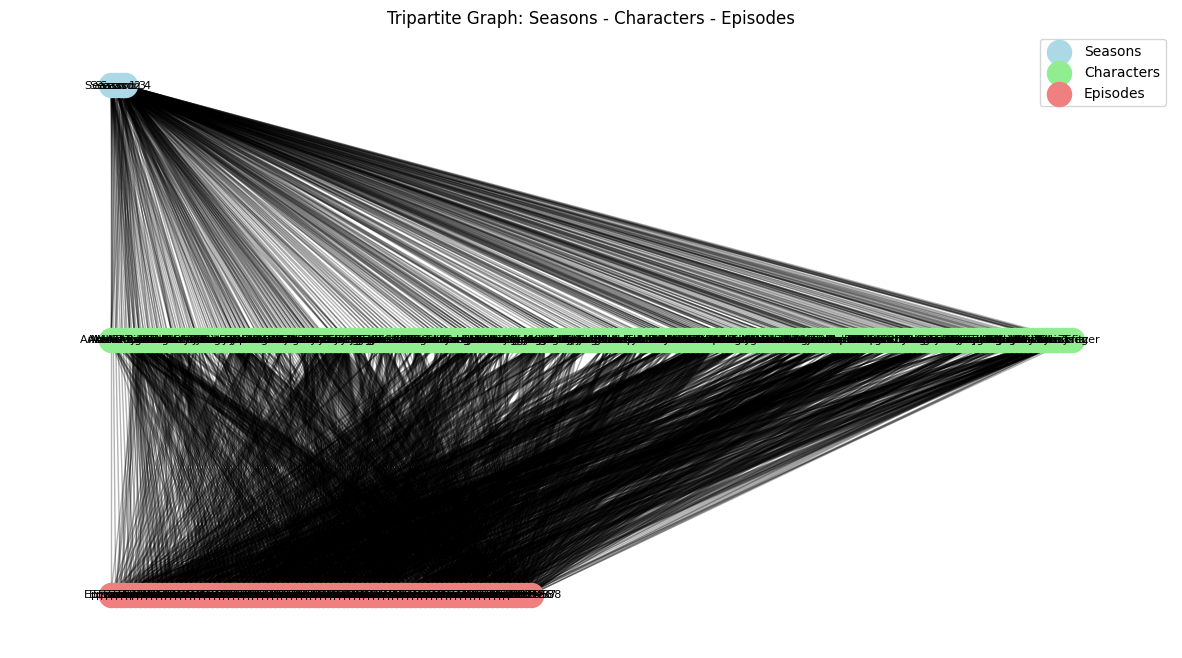

In [11]:
# =========================================================
# Cell 9: Plot the Graph Directly in the Notebook (Task 5)
# =========================================================
# We will create a manual layout to place:
#   - Seasons at the top (y = 3)
#   - Characters in the middle (y = 2)
#   - Episodes at the bottom (y = 1)
#
# For simplicity, we'll place them in a line or somewhat spaced out.

pos = {}
x_offset_season = 0
x_offset_char = 0
x_offset_ep = 0

# Position the season nodes (layer="season")
season_nodes = [n for n, d in G.nodes(data=True) if d.get("layer") == "season"]
for i, s_node in enumerate(sorted(season_nodes)):
    pos[s_node] = (i, 3)

# Position the character nodes (layer="character")
char_nodes = [n for n, d in G.nodes(data=True) if d.get("layer") == "character"]
for i, c_node in enumerate(sorted(char_nodes)):
    pos[c_node] = (i, 2)

# Position the episode nodes (layer="episode")
episode_nodes = [n for n, d in G.nodes(data=True) if d.get("layer") == "episode"]
for i, e_node in enumerate(sorted(episode_nodes, key=lambda x: G.nodes[x]['episode_number'])):
    pos[e_node] = (i, 1)

# Plot
plt.figure(figsize=(15, 8))
nx.draw_networkx_nodes(G, pos, nodelist=season_nodes, node_color='lightblue', label='Seasons')
nx.draw_networkx_nodes(G, pos, nodelist=char_nodes, node_color='lightgreen', label='Characters')
nx.draw_networkx_nodes(G, pos, nodelist=episode_nodes, node_color='lightcoral', label='Episodes')

nx.draw_networkx_edges(G, pos, edgelist=G.edges(), alpha=0.3)
nx.draw_networkx_labels(G, pos, font_size=8)

plt.title("Tripartite Graph: Seasons - Characters - Episodes")
plt.axis('off')
plt.legend()
plt.show()


Plot for Season 1:


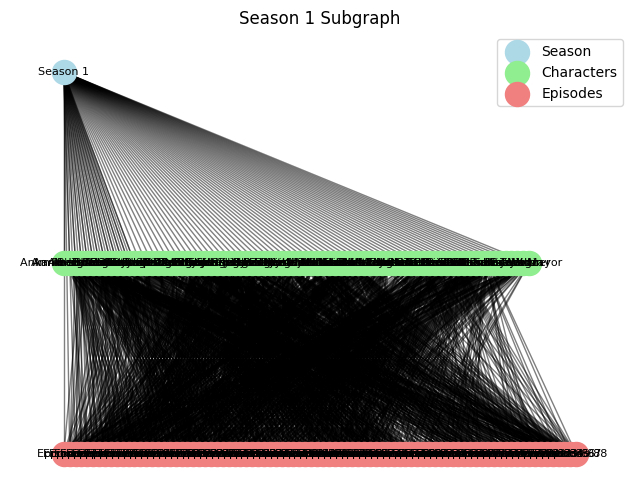

Plot for Season 2:


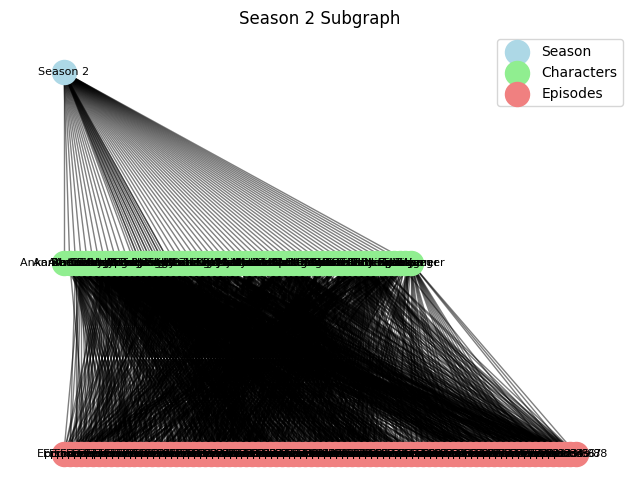

Plot for Season 3:


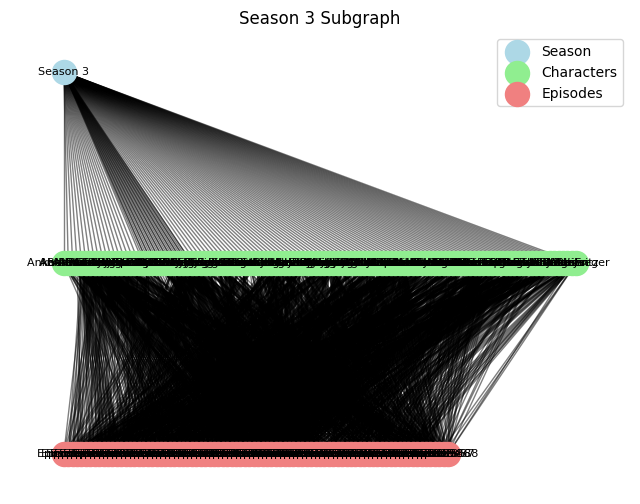

Plot for Season 4:


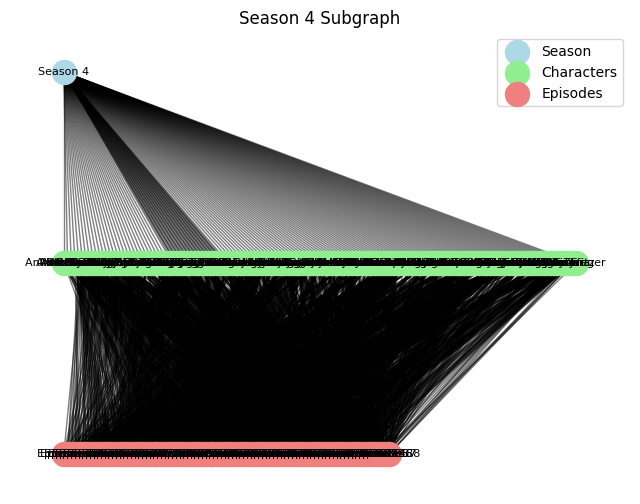

In [12]:
# =========================================================
# Cell 10: Create Independent Plots for Each Season (Task 6)
# =========================================================

def plot_season_graph(season):
    """
    Plot a subgraph with:
      - The given season node at the top
      - Characters that appear in this season in the middle
      - Episodes in the bottom
    """
    # Validate that the season node exists
    season_node = f"Season {season}"
    if season_node not in G.nodes:
        print(f"Season {season} is not in the graph.")
        return
    
    # Create a subgraph containing only:
    #   - The season node
    #   - The characters connected to the season
    #   - The episodes connected to those characters and the season
    connected_chars = [n for n in G[season_node] if G.nodes[n].get('layer') == 'character']
    connected_episodes = []
    
    for c in connected_chars:
        # Episodes connected to the character
        for ep in G[c]:
            if G.nodes[ep].get('layer') == 'episode':
                connected_episodes.append(ep)
                
    # Also episodes directly connected to the season node
    # (though they should be the same ones, but we'll combine them to be safe)
    for ep in G[season_node]:
        if G.nodes[ep].get('layer') == 'episode':
            connected_episodes.append(ep)
    
    # Deduplicate
    connected_episodes = list(set(connected_episodes))
    
    # Create subgraph
    nodes_of_interest = [season_node] + connected_chars + connected_episodes
    subG = G.subgraph(nodes_of_interest)
    
    # Build layout
    pos_sub = {}
    
    # Season node at top
    pos_sub[season_node] = (0, 2)
    
    # Place characters in the middle
    for i, char_node in enumerate(sorted(connected_chars)):
        pos_sub[char_node] = (i, 1)
        
    # Place episodes at the bottom
    for j, ep_node in enumerate(sorted(connected_episodes, key=lambda x: G.nodes[x]['episode_number'])):
        pos_sub[ep_node] = (j, 0)
    
    plt.figure(figsize=(8, 6))
    nx.draw_networkx_nodes(subG, pos_sub, nodelist=[season_node], node_color='lightblue', label='Season')
    nx.draw_networkx_nodes(subG, pos_sub, nodelist=connected_chars, node_color='lightgreen', label='Characters')
    nx.draw_networkx_nodes(subG, pos_sub, nodelist=connected_episodes, node_color='lightcoral', label='Episodes')
    
    nx.draw_networkx_edges(subG, pos_sub, alpha=0.5)
    nx.draw_networkx_labels(subG, pos_sub, font_size=8)
    
    plt.title(f"Season {season} Subgraph")
    plt.axis('off')
    plt.legend()
    plt.show()

# Demonstrate plotting each season in separate plots
for season_num in [1, 2, 3, 4]:
    print(f"Plot for Season {season_num}:")
    plot_season_graph(season_num)
    print("="*50)


In [13]:
# =======================================================================
# Cell 11: Interactive Plot Selection (Task 7)
# =======================================================================
def analyze_season():
    """
    Asks the user which season they want to analyze (1-4).
    Plots the graph for that season. 
    Validates input and returns an error message if invalid.
    """
    valid_seasons = [1, 2, 3, 4]
    user_input = input("Enter a season number (1, 2, 3, or 4): ")
    
    try:
        season_selected = int(user_input)
        if season_selected not in valid_seasons:
            print("Error: Invalid season number. Please choose 1, 2, 3, or 4.")
            return
        
        print(f"\nPlotting subgraph for Season {season_selected}...")
        plot_season_graph(season_selected)
        
    except ValueError:
        print("Error: Please enter a valid integer (1, 2, 3, or 4).")

# You can call analyze_season() to prompt the user.
# Example usage (uncomment to test in an interactive notebook):
# analyze_season()



Plotting subgraph for Season 3...


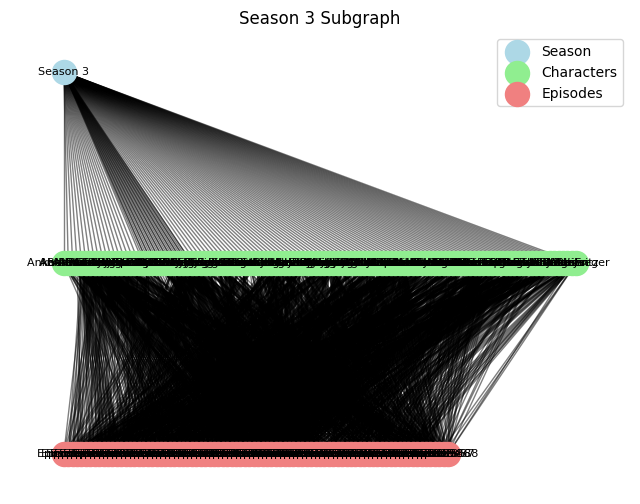

In [15]:
analyze_season()

In [17]:
# =========================================================
# Cell 3: Build the Full Tripartite Graph
# (Optional Step for Reference)
# =========================================================

G_full = nx.Graph()

# Add seasons
seasons_list = [1, 2, 3, 4]
for s in seasons_list:
    G_full.add_node(f"Season {s}", layer="season", season_number=s)

# Add characters
for idx, row in df_cleaned.iterrows():
    char_name = row["name"]
    G_full.add_node(char_name, layer="character")

# Gather all episode numbers
all_episode_numbers = set()
for episodes in df_cleaned["episodes"]:
    for ep_url in episodes:
        all_episode_numbers.add(get_episode_number(ep_url))

# Add episodes
for ep in sorted(all_episode_numbers):
    G_full.add_node(f"Episode {ep}", layer="episode", episode_number=ep)

# Add edges
# (season, character)
for _, row in df_cleaned.iterrows():
    char_name = row["name"]
    for s in row["seasons"]:
        G_full.add_edge(f"Season {s}", char_name)

# (character, episode)
for _, row in df_cleaned.iterrows():
    char_name = row["name"]
    for ep_url in row["episodes"]:
        ep_num = get_episode_number(ep_url)
        G_full.add_edge(char_name, f"Episode {ep_num}")

# (season, episode)
for ep in all_episode_numbers:
    s = determine_season(ep)
    if s is not None:
        G_full.add_edge(f"Season {s}", f"Episode {ep}")

print("Full tripartite graph built.")
print("Number of nodes:", G_full.number_of_nodes())
print("Number of edges:", G_full.number_of_edges())

# Optionally export the full graph
# nx.write_gml(G_full, "tripartite_full.gml")


Full tripartite graph built.
Number of nodes: 292
Number of edges: 2695


In [18]:
# =========================================================
# Cell 4: Create Bipartite Subgraphs for Each Season
# =========================================================

def build_season_subgraph(df, season):
    """
    Builds a subgraph for a single season, containing:
      - The single season node
      - Characters in that season
      - Episodes belonging to that season
    Edges:
      - (season, character) if character appears in that season
      - (character, episode) if that character is in that episode
      - (season, episode) if that episode belongs to that season
    """
    # Create empty graph
    G_season = nx.Graph()
    
    # 1) Add season node
    season_node = f"Season {season}"
    G_season.add_node(season_node, layer="season", season_number=season)
    
    # 2) Find all characters that appear in this season
    season_chars = df[df["seasons"].apply(lambda s_list: season in s_list)]
    
    for _, row in season_chars.iterrows():
        char_name = row["name"]
        # Add character node
        G_season.add_node(char_name, layer="character")
        # Add edge (season, character)
        G_season.add_edge(season_node, char_name)
        
    # 3) For each character, gather episodes that fall into the given season
    #    Also keep track of all unique episodes in this season
    season_episodes = set()
    for _, row in season_chars.iterrows():
        char_name = row["name"]
        for ep_url in row["episodes"]:
            ep_num = get_episode_number(ep_url)
            if determine_season(ep_num) == season:
                # Add episode node
                ep_node = f"Episode {ep_num}"
                G_season.add_node(ep_node, layer="episode", episode_number=ep_num)
                season_episodes.add(ep_node)
                
                # Add edge (character, episode)
                G_season.add_edge(char_name, ep_node)
    
    # 4) Add edges (season, episode)
    for ep_node in season_episodes:
        G_season.add_edge(season_node, ep_node)
    
    return G_season

# Build subgraphs for each season
season_graphs = {}
for s in [1, 2, 3, 4]:
    subG = build_season_subgraph(df_cleaned, s)
    season_graphs[s] = subG
    print(f"Season {s} subgraph has {subG.number_of_nodes()} nodes and {subG.number_of_edges()} edges.")

# Optionally, export each subgraph to GML
'''for s in [1, 2, 3, 4]:
    filename = f"season_{s}_subgraph.gml"
    nx.write_gml(season_graphs[s], filename)
    print(f"Exported Season {s} subgraph to {filename}")
'''

Season 1 subgraph has 106 nodes and 598 edges.
Season 2 subgraph has 73 nodes and 345 edges.
Season 3 subgraph has 140 nodes and 780 edges.
Season 4 subgraph has 168 nodes and 972 edges.
Exported Season 1 subgraph to season_1_subgraph.gml
Exported Season 2 subgraph to season_2_subgraph.gml
Exported Season 3 subgraph to season_3_subgraph.gml
Exported Season 4 subgraph to season_4_subgraph.gml


In [21]:
# =========================================================
# Cell 2: Load and Preprocess Data (same logic as before)
# =========================================================

DATA_PATH = "/Users/michelecoaro/Documents/GitHub/AOT_Network/Data/characters.json"

with open(DATA_PATH, 'r', encoding='utf-8') as f:
    data = json.load(f)

df = pd.json_normalize(data)

# Keep only the specified columns
columns_to_keep = ["id", "name", "alias", "species", "groups", "roles", "episodes"]
df_cleaned = df[columns_to_keep].copy()

def get_episode_number(url):
    return int(url.rstrip('/').split('/')[-1])

def determine_season(ep_num):
    if 1 <= ep_num <= 25:
        return 1
    elif 26 <= ep_num <= 37:
        return 2
    elif 38 <= ep_num <= 59:
        return 3
    elif 60 <= ep_num <= 94:
        return 4
    else:
        return None

def get_character_seasons(episodes):
    seasons = set()
    for ep_url in episodes:
        ep_num = get_episode_number(ep_url)
        s = determine_season(ep_num)
        if s is not None:
            seasons.add(s)
    return sorted(list(seasons))

df_cleaned["seasons"] = df_cleaned["episodes"].apply(get_character_seasons)

df_cleaned.head()


,id,name,alias,species,groups,roles,episodes,seasons
0,1,Armin Arlelt,[Colossal Titan],"[Human, Intelligent Titan]","[{'name': 'Scout Regiment', 'sub_groups': ['Sp...","[Colossal Titans, Scout Regiment Commanders]","[https://api.attackontitanapi.com/episodes/1, ...","[1, 2, 3, 4]"
1,2,Mikasa Ackermann,[],[Human],"[{'name': 'Scout Regiment', 'sub_groups': ['Sp...",[],"[https://api.attackontitanapi.com/episodes/1, ...","[1, 2, 3, 4]"
2,3,Jean Kirschtein,[Horse face],[Human],"[{'name': 'Scout Regiment', 'sub_groups': ['Sp...",[],"[https://api.attackontitanapi.com/episodes/2, ...","[1, 2, 3, 4]"
3,4,Conny Springer,[],[Human],"[{'name': 'Scout Regiment', 'sub_groups': ['Sp...",[],"[https://api.attackontitanapi.com/episodes/1, ...","[1, 2, 3, 4]"
4,5,Levi Ackermann,[Humanity's Strongest Soldier],[Human],"[{'name': 'Scout Regiment', 'sub_groups': ['Sp...",[],"[https://api.attackontitanapi.com/episodes/2, ...","[1, 2, 3, 4]"


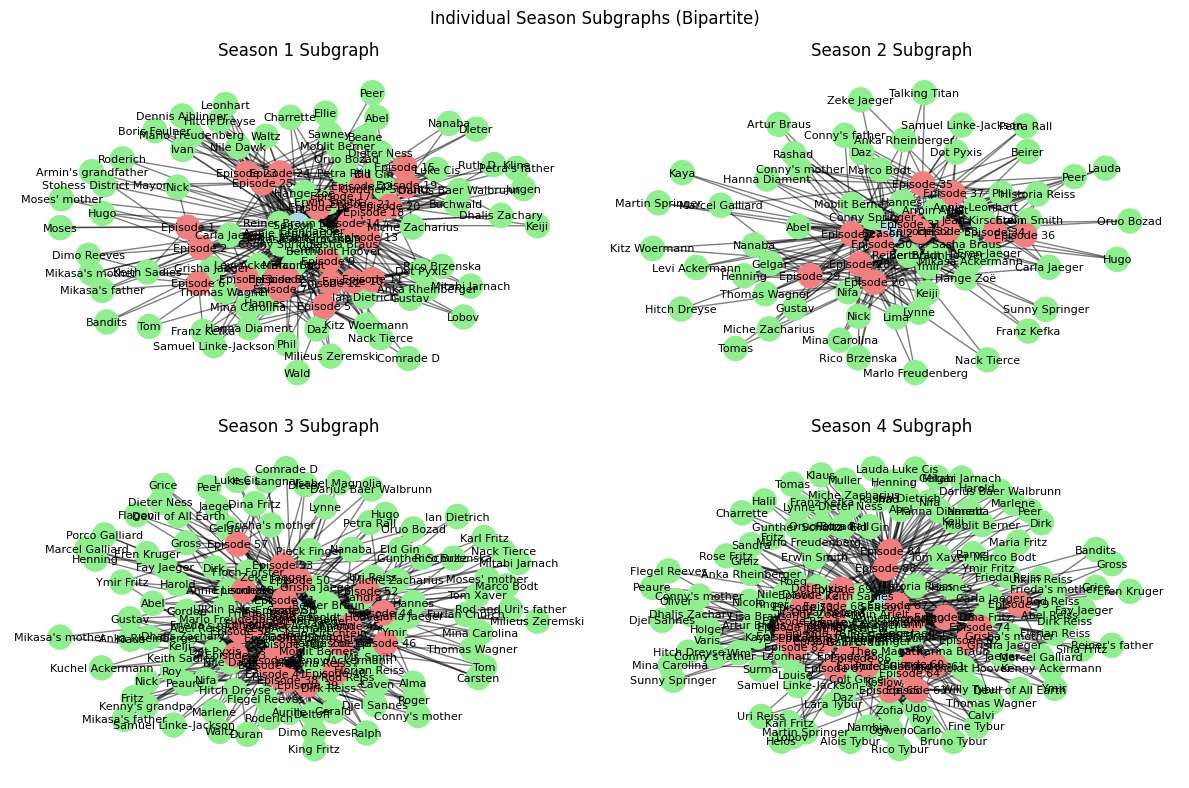

In [25]:
# =====================================================================
# Cell 4: Optional - Show All Subgraphs in a Single Figure with Subplots
# =====================================================================

def get_node_color(node, graph):
    """Assign a color based on the 'layer' attribute."""
    layer = graph.nodes[node].get("layer")
    if layer == "season":
        return "lightblue"
    elif layer == "character":
        return "lightgreen"
    elif layer == "episode":
        return "lightcoral"
    else:
        return "grey"

fig, axes = plt.subplots(2, 2, figsize=(12, 8))
fig.suptitle("Individual Season Subgraphs (Bipartite)")

season_list = [1, 2, 3, 4]

for idx, s in enumerate(season_list):
    ax = axes[idx // 2, idx % 2]
    G_s = season_graphs[s]
    
    # Use a layout algorithm, e.g. spring_layout or bipartite_layout
    # bipartite_layout requires you to specify two sets, which can be tricky here.
    # We'll just go with spring_layout for a quick aesthetic.
    pos = nx.spring_layout(G_s, seed=42)  # seed for reproducibility
    
    # Draw nodes with color
    node_colors = [get_node_color(n, G_s) for n in G_s.nodes()]
    nx.draw_networkx_nodes(G_s, pos, ax=ax, node_color=node_colors)
    
    # Draw edges
    nx.draw_networkx_edges(G_s, pos, ax=ax, alpha=0.5)
    
    # Draw labels
    nx.draw_networkx_labels(G_s, pos, ax=ax, font_size=8)
    
    ax.set_title(f"Season {s} Subgraph")
    ax.axis("off")

plt.tight_layout()
plt.show()


In [28]:
# =============================================================
# Cell 5: Merge All Season Subgraphs into One Big Graph
# =============================================================
merged_graph = reduce(nx.compose, [season_graphs[s] for s in [1, 2, 3, 4]])

print("Merged graph -> Nodes:", merged_graph.number_of_nodes())
print("Merged graph -> Edges:", merged_graph.number_of_edges())


Merged graph -> Nodes: 283
Merged graph -> Edges: 2695


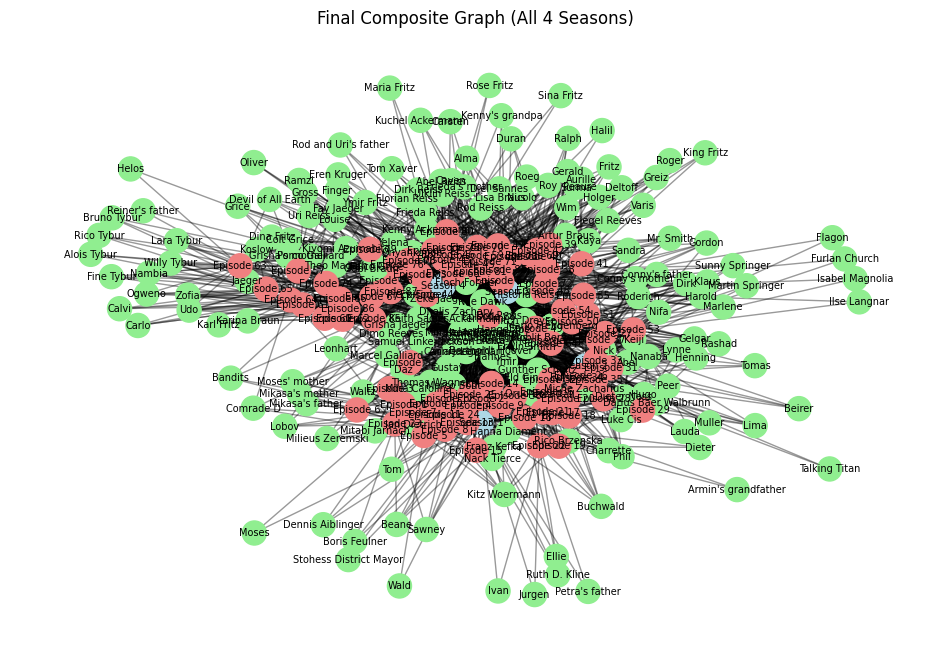

In [29]:
# =============================================================
# Cell 6: Visualize the Final Composite Graph
# =============================================================
plt.figure(figsize=(12, 8))
pos_merged = nx.spring_layout(merged_graph, seed=42)

node_colors = []
for node in merged_graph.nodes():
    node_colors.append(get_node_color(node, merged_graph))

nx.draw_networkx_nodes(merged_graph, pos_merged, node_color=node_colors)
nx.draw_networkx_edges(merged_graph, pos_merged, alpha=0.4)
nx.draw_networkx_labels(merged_graph, pos_merged, font_size=7)

plt.title("Final Composite Graph (All 4 Seasons)")
plt.axis("off")
plt.show()
